# Problem Formulation

With this analysis, we want to tackle the challenge of classifying various satellite images to differentiate between multiple classes. One of the biggest challenges with regards to sustainable development is for an economy to grow while not exhausting the present natural resources. As such, a deep learning model that can classify the content of a satellite images accurately would be of great benefit when trying to draw more holistic insights on land use - for example how much of a certain area is occupied with agriculture, how much forests remain untouched and how much urban infrastructure has been established. Applying such deep learning model to satellite images throughout time could then reveal development patterns of land use and land cover.

Therefore, within this paper we try to build a CNN model that accurately predicts and classifies satellite images in ten different classes. We will first begin by loading the necessary packages and dataset we'll work with.

In [1]:
# import all libraries that we may need for our analysis
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline
import skimage
from skimage.io import imshow, imread
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, GlobalMaxPooling2D
from keras.models import Sequential 
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import BatchNormalization
from keras.callbacks import LearningRateScheduler
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.preprocessing import image
import os
import cv2

NB: The following cell of code is just necessary if you want to delete the directory for testing purposes. Please remove the # in case you want to re-run the noteboook.

In [2]:
#import shutil
#shutil.rmtree('2750')
#shutil.rmtree('Data')
#os.remove('EuroSAT.zip')

The first step in our analysis it to upload our data and unzip it. As we're working with image data that requires a much larger amount of storage than other types of data, we will not store it inside a pandas dataframe, but in the file directory.

In [3]:
# load the data
!wget http://madm.dfki.de/files/sentinel/EuroSAT.zip
!unzip -qq EuroSAT.zip 

--2020-12-09 13:06:43--  http://madm.dfki.de/files/sentinel/EuroSAT.zip
Resolving madm.dfki.de (madm.dfki.de)... 131.246.195.183
Connecting to madm.dfki.de (madm.dfki.de)|131.246.195.183|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94280567 (90M) [application/zip]
Saving to: ‘EuroSAT.zip’

EuroSAT.zip         100%[===================>]  89.91M  11.9MB/s    in 14s     

2020-12-09 13:06:57 (6.58 MB/s) - ‘EuroSAT.zip’ saved [94280567/94280567]



# Exploratory Data Analysis
As always, as first step of preprocessing we'll dive into an exploratory analysis of the dataset at hand, checking first what the pictures look like as well as the distribution of such pictures in the different classes. Since we are dealing with image data, the first thing we want to provide is an overview of what kind of pictures we're dealing with. We do so by first specifying the directory through which the data can be accessed and then creating a *for loop* that iterates through the folders and selects a random image from each class to show. We then show the pictures using matplotlib.

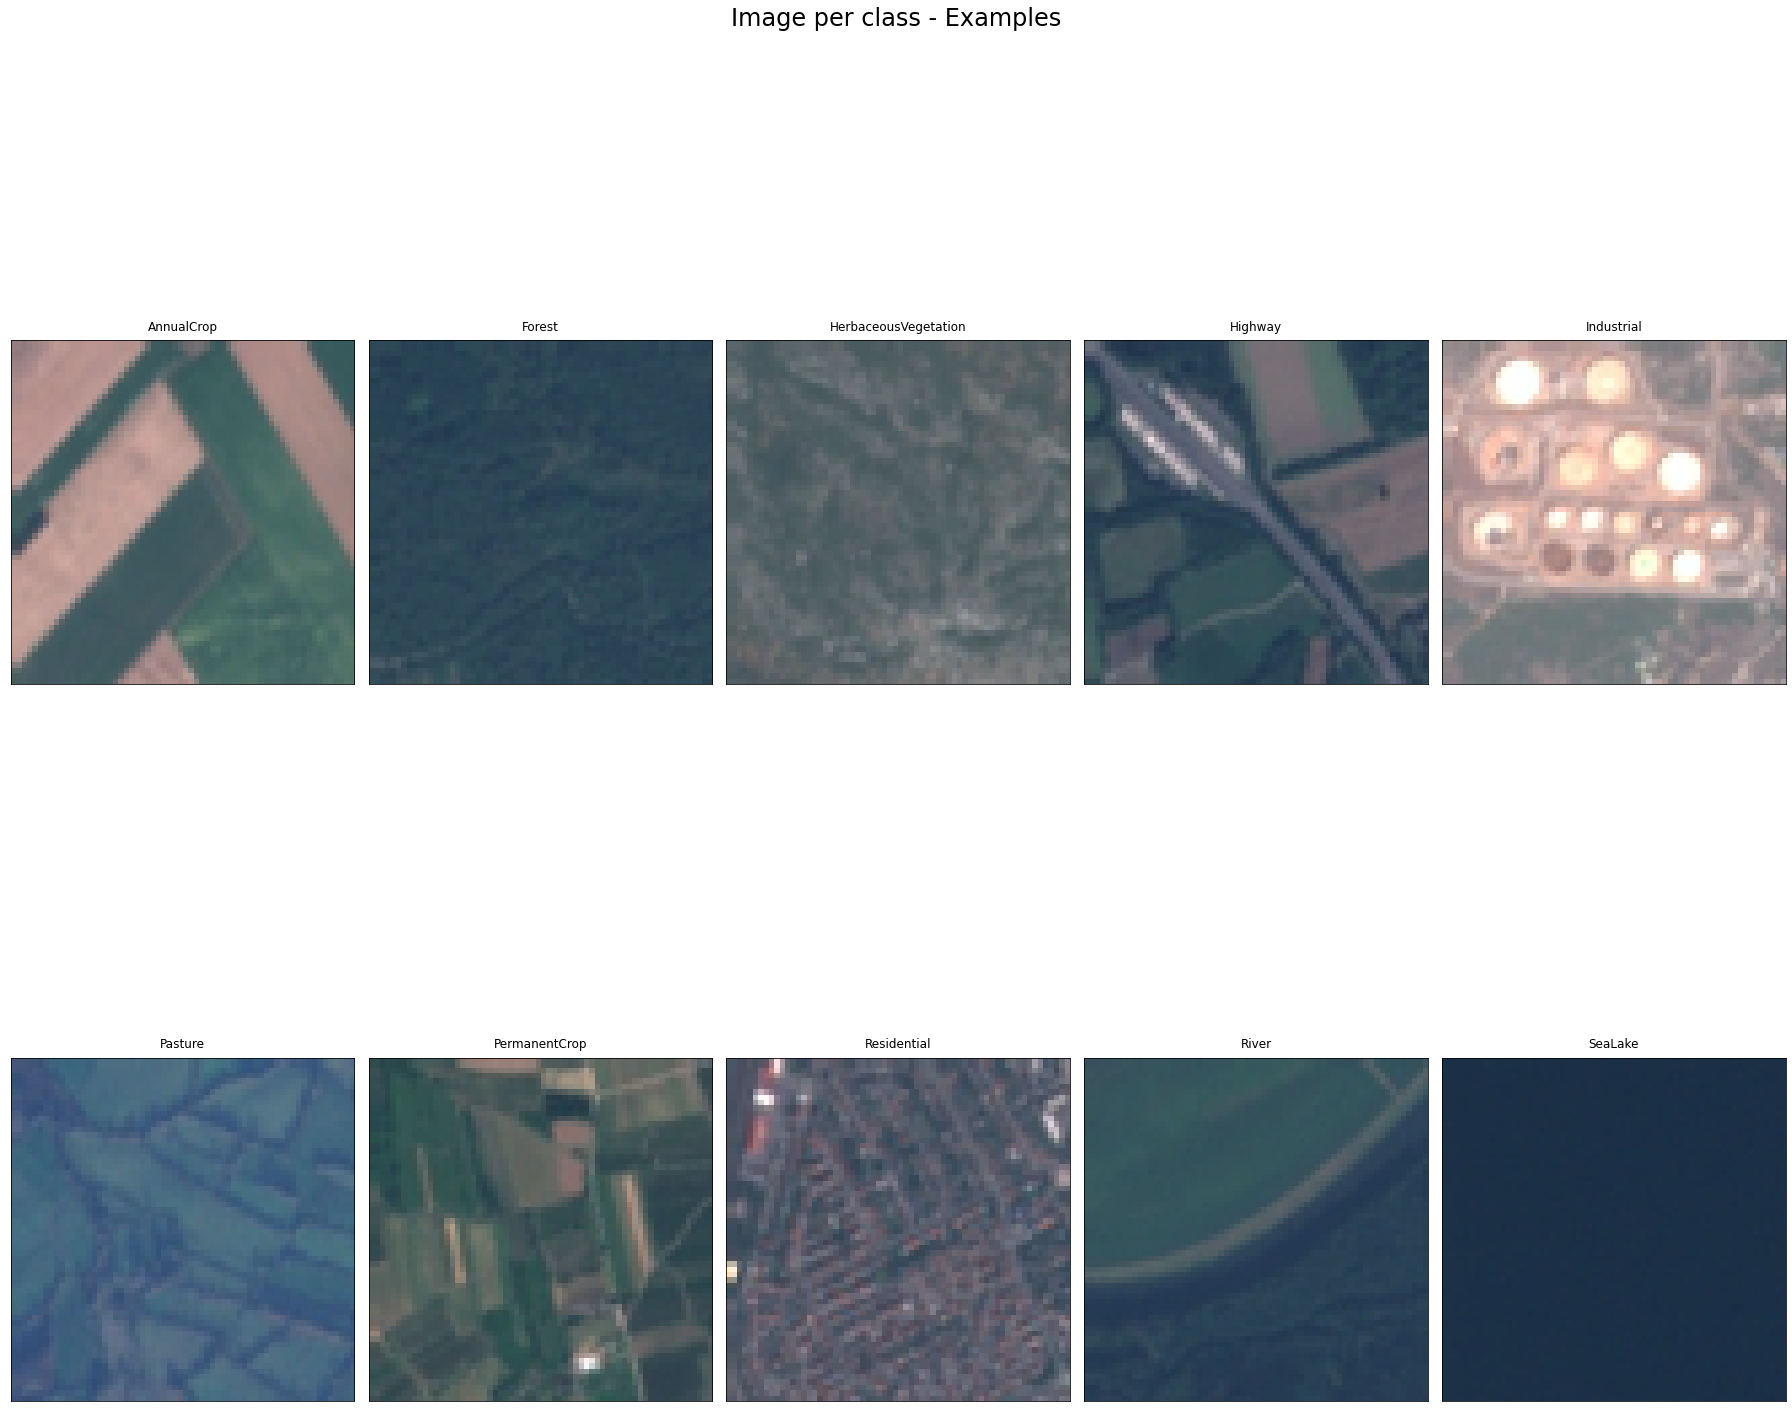

In [4]:
#visualize one image per class to get a sense of the dataset
#defining how the plot should look like
rows = 2
cols = 5
fig, ax = plt.subplots(rows, cols, figsize=(25,25))
fig.suptitle("Image per class - Examples", fontsize=24) # fontsize=24 helped me fix the suptitle overlapping with axes issue

#directions to access the data
data_dir = "2750/"
satellites_sorted = sorted(os.listdir(data_dir))
satellites_id = 0

#loop to create the plots
for i in range(rows):
  for j in range(cols):
    try:
      satellites_selected = satellites_sorted[satellites_id] 
      satellites_id += 1
    except:
      break
    if satellites_selected == '.DS_Store':
        continue
    satellites_selected_images = os.listdir(os.path.join(data_dir,satellites_selected)) # returns the list of all files present in each food category
    satellites_selected_random = np.random.choice(satellites_selected_images) # picks one food item from the list as choice, takes a list and returns one random item
    img = plt.imread(os.path.join(data_dir,satellites_selected, satellites_selected_random))
    ax[i][j].imshow(img)
    ax[i][j].set_title(satellites_selected, pad = 10)

#show picture-plots one next to the other   
plt.setp(ax, xticks=[],yticks=[])
plt.tight_layout()

After now seeing how the pictures with each class roughly look like, the next thing we want to do is inspect the distribution of images across the different classes to see if the amount of images per class is equally distributed. Again, we can visualize this by simply applying a *for loop* and using matplotlib.

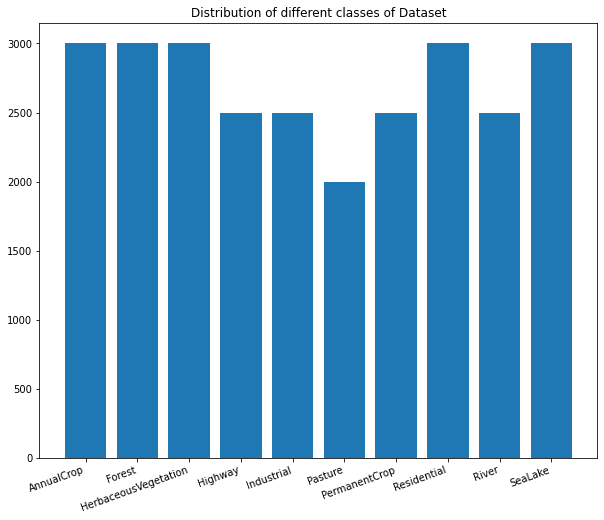

In [5]:
# let's chech how many images we have for each class
image_folder = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
nimgs = {}
for i in image_folder:
    nimages = len(os.listdir('2750/'+i+'/'))
    nimgs[i]=nimages
    
plt.figure(figsize=(10, 8))
plt.bar(range(len(nimgs)), list(nimgs.values()), align='center')
plt.xticks(range(len(nimgs)), list(nimgs.keys()), rotation=20, horizontalalignment='right')
plt.title('Distribution of different classes of Dataset')
plt.show()

Looking at above visualization shows that altough not having the exact same amount of pictures per class, the amount of images within our classes is in general distributed relatively equally. To get an even better understanding of this distribution we have below attached a pie chart showcasing the pecentage distribution per class.

<Figure size 864x720 with 0 Axes>

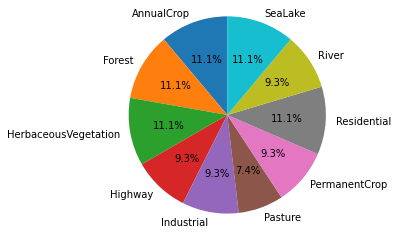

In [6]:
#pie plot for additional perspective
plt.figure(figsize=(12, 10))
labels = image_folder
sizes = list(nimgs.values())

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=False, startangle=90)
ax1.axis('equal')
plt.show()

We can deduct that we are dealing with a fairly well balanced dataset, each of the ten classes contains about 10% of the total images that are present in the dataset, with only _Pasture_ being relatively smaller in comparison to the others (7.4%).

# Data processing for non-neural baseline model

Before trying out any deep learning models, we first want to see how a non-neural baseline model performs on the data at hand. In our case, we're going to use the RandomForestClassifier for the multiclass classification problem we're facing and therefore, our image data needs to be preprocessed and converted before we can train a machine learning model with it.

### Feature extraction
In order to work with a dataset of images like ours and a non-neural baseline model, first we need to extract different features within the picture to identify and categorize images based on features or aspects.

Images store lots of information, and pre-processing them helps extract useful information: in a way, it is a sort of dimensionality reduction, compressing the high number of information a picture's pixels store into few significant features.

To acceess these different pictures we will make use of _scikit-image_, a collection of algorithms for image processing. Among other things this package can help with edge detection and to draw out pixels features.



####Edge Detection
As will be shown below, detecting edges, which are the corners where the pixel change drastically, can be used to extract the structure of objects in an image. Especially when working with images and object recognition, edge detection helps us to focus on the most important part of the picture (the objects) while ignoring other unnecessary features.

Here is an example: first we load a random image and convert it in a grey scale.
Converting an image to its grey scale is a crucial step when processing pictures for object identification: the image-binarization will help in sharpening the image by identifying the light and dark areas and thus, bring out out more of the structure within the picture.

Finally we will apply Canny, a very popular algorithm for edge detection.

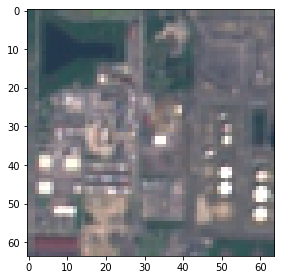

In [7]:
#read a random chosen picture from Industrial folder
img_ind = imread('/content/2750/Industrial/Industrial_1011.jpg')
imshow(img_ind)

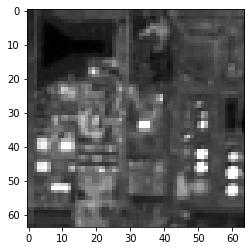

In [8]:
#convert it to grey
img_ind_grey = skimage.color.rgb2gray(img_ind)
plt.imshow(img_ind_grey, cmap='gray')

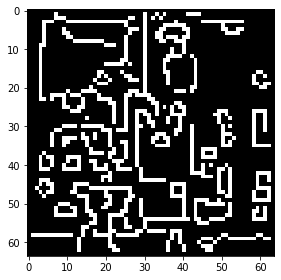

In [9]:
#Canny algorithm
from skimage.feature import canny 
can = canny(img_ind_grey)

#show
imshow(can, cmap= 'gray')

As it can be seen above, through Canny many of the features that were perhaps not so apparent in when looking at the sample are now highlighted in a black and white contrast pattern, making it easier for a ML model to detect patterns and classify images.

#### Images as arrays (of pixels)
For the sake of this assignment, however, we will not focus on edge detection but will instead make use of the pixels as raw values.
We will read and reshape them into a *np_array*, switching from a visual representation to a numerical one, as shown below.

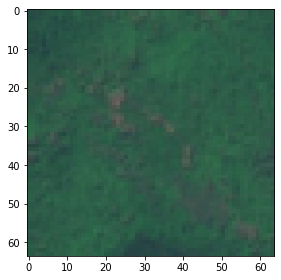

In [10]:
#chose random image from forest folder
img_for = imread('/content/2750/Forest/Forest_1067.jpg')
imshow(img_for);

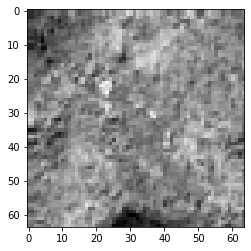

In [11]:
#convert it in greyscale
img_for_grey = skimage.color.rgb2gray(img_for)
plt.imshow(img_for_grey, cmap='gray')

In [12]:
#image shape (for reference in reshaping)
print(img_for_grey.shape)

(64, 64)


In [13]:
#reshaping the image dimension into an array
pixel_img_for_grey = np.reshape(img_for_grey, (64*64))
pixel_img_for_grey

array([0.25933294, 0.2590502 , 0.2708149 , ..., 0.30224863, 0.31401333,
       0.2991298 ])

This brief intro to image feature extraction was to show was "goes into" a non-neural baseline model and was to show how to preprocess data accordingly. In the next step, we will now build the RandomForestClassier model.

### RandomForestClassifier

The first steps in building our baseline model are to specify the data directory, categories and image size, which are then used as input variables to the function that creates our training data. This function creates an array out of the image data (similar to what was shown before), resizes it and then appends it to our training data. Afterwards, we randomly shuffle our data.

As mentioned before, to apply a RandomForestClassifier to our data, we need the data in form of an array.

In [14]:
# here we define the data directory and the different categories that are present
DATADIR='2750/'
CATEGORIES=['AnnualCrop','Forest', 'HerbaceousVegetation','Highway','Industrial','Pasture','PermanentCrop','Residential','River','SeaLake']

# specify image size
IMG_SIZE=64

In [15]:
# define function and create training data
training_data=[]

def create_training_data(): # define function
    for category in CATEGORIES:
        path=os.path.join(DATADIR, category)#path directory
        class_num=CATEGORIES.index(category)#class categories
        for img in os.listdir(path):
            try:
                img_array=cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)#transform images to array
                new_array=cv2.resize(img_array,(IMG_SIZE,IMG_SIZE)) #resizing the arrays
                training_data.append([new_array,class_num])#append them to our data
            except Exception as e:
                pass
                
create_training_data()

In [16]:
# random shuffle the data
import random
random.shuffle(training_data)

Now we are specifying X and y, which we will later draw our train and test data from, respectively.

While **X** contains the actual image information in form of categories, **y** is the label of each image indicating to what class it belongs to. However, before we can feed X and y into out RandomForestClassifier, we first need to rescale X to only having two dimensions, as this is a requirement of the RandomForestClassifier.

In [17]:
# specify x and y value
X=[]
y=[]

for categories, label in training_data:
    X.append(categories)#append categories to X
    y.append(label)#append labels to y
#reshaping
X= np.array(X).reshape(-1, IMG_SIZE*IMG_SIZE*1) # we are reshaping to a 2D array as we need such an array as input ofr our model

In [18]:
# check if x has the correct shape
X.shape

(27000, 4096)

Below, we have created another instance of X which we again reshaped only for visualization purposes. For the sake of machine learning, we will stick with the two dimensional image representation in form of an array. However, we want to showcase the actual picture next to an array representation to give a bit more context in terms of what is happening to the picture and what sort of data the model is later trained with.

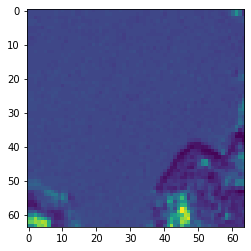

In [19]:
#image visualization
X1=X.reshape(X.shape[0],IMG_SIZE,IMG_SIZE) #reshape for visualization purposes
plt.imshow(X1[100]) #plotting a random image of index 100
plt.show() 

In [20]:
#showing the respective array of the image
X1[100]

array([[ 57,  57,  57, ...,  79,  67,  52],
       [ 57,  57,  57, ...,  79,  66,  52],
       [ 57,  57,  55, ...,  58,  58,  58],
       ...,
       [ 93,  93, 104, ...,  51,  53,  51],
       [ 98,  98, 104, ...,  52,  53,  49],
       [ 76,  76,  88, ...,  50,  52,  52]], dtype=uint8)

Now it is time to fit a machine learning model to our data to see if we can accurately classify the different images. The first step in doing so is to make sure we have all necessary packages from the *sklearn* library. Next, we apply the *train_test_split* function to our data to generate a training set and a test set (or validation set). We specify the size of this test set to be 0.25, meaning that 75% of the data is used for training and 25% for testing. After splitting the data, we fit the RandomForestClassifier to our data and inspect the accuracy as well as other metrics from the classification.

In [21]:
#import sklearn packages for SML
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [22]:
# splitting our data into a train and a test set
x_train,x_val,y_train,y_val = train_test_split(X,y, test_size=0.25, random_state=1)

In [23]:
# fit the RandomForestClassifier on our data
random_forest = RandomForestClassifier(n_estimators=100, random_state=10).fit(x_train, y_train)
y_pred = random_forest.predict(x_val)
# print the accuracy
print('Accuracy score: ' + str(accuracy_score(y_val, y_pred)))

Accuracy score: 0.5568888888888889


In [24]:
# Metrics
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_val,y_pred))
print(classification_report(y_val,y_pred))

[[484   4  55  15  34  24  39  18  52  13]
 [  0 689   4   0   0  47   0   0   4  21]
 [ 77  16 198  33  18  93  87 119  89   9]
 [ 75  21  48 155  35  26  47 106 138   1]
 [ 21   0   4  17 502   0  23  60   4   0]
 [  3  34 101   5   0 247   3  52  40  11]
 [186   2  87  15  40  19 137 114  30   0]
 [ 28   0  46  23  66  22  90 435  28   0]
 [ 47  47  40  49   7  70   3  53 293   2]
 [  7  93  12   0   0  14   0   0   5 619]]
              precision    recall  f1-score   support

           0       0.52      0.66      0.58       738
           1       0.76      0.90      0.82       765
           2       0.33      0.27      0.30       739
           3       0.50      0.24      0.32       652
           4       0.72      0.80      0.75       631
           5       0.44      0.50      0.47       496
           6       0.32      0.22      0.26       630
           7       0.45      0.59      0.51       738
           8       0.43      0.48      0.45       611
           9       0.92     

Looking at above accuracy score of the RandomForestClassifier we see that it achieves a little more than 50% accuracy, which is not particularly good in our opinion. Furthermore, the confusion matrix and classification report reveal that the precision and recall score strongly differ across the different classes. The reason for this is most likely that some classes contain certain image features that are easy to distinguish for the model, why other classes might contain more ambiguous features. All in all, although the model does not perform particularly bad, we think there is still a lot of room for improvement when we apply a deep learning model that will iterate our data through multiple instances. Hence, in the next step, we will begin pre-processing our data for the deep learning model.

# Data preprocessing and augmentation for deep learning

Before continuing with building the intended prediction models, we first want to apply some data preprocessing to make sure the data is optimized for later use. In order to make the most out of the training set images, we will also "augment" the satellite images via a number of random transformations, so that our model would never see twice the exact same picture. This helps prevent overfitting and helps the model generalize better. 

However, our first step is to install and import the split folders function. The reason for this is that although our data is sorted in folders indicating what the images depict, it does not yet come with a *train and test* set of pictures. The *splitfolders.ratio* command helps us to split the folders into two different sets, where we specify the ration to be 0.85 (later used for the training data) and 0.15 (which is later used for the test data). We chose a rather large percentage of the dataset for training as convolutional neural networks work best with a large training database.

In [25]:
# install split folders
!pip install split-folders

In [26]:
#import the package
import splitfolders

In [27]:
#split with a ratio 0.85-0.15
splitfolders.ratio('2750', output='Data', seed=1337, ratio=(0.85, 0.15), group_prefix=None) # default values

Copying files: 27000 files [00:04, 6173.97 files/s]


Now that we have our folder structure ready, we can start initiating image augmentation instances. We use the _ImageDataGenerator_ from _Keras_ for this purpose. The goal of this image augmentation is to change certain specifics about the pictures without changing its label. In the present case, we are augmenting the images in the training set by rotating them, shifting their heigth and width, as well as rescaling, distorting, zooming and flipping them. For the test data, we only scale the pictures.

That way, our model learns to see the same image from different perspectives and is able to better classify its content, also keeping in mind that future pictures that may be fed into the model may look slightly different than the ones we're dealing with now.

In [28]:
#importing the Keras-Image-Data-Generator
from keras.preprocessing.image import ImageDataGenerator

In [29]:
# image augmentation
train_datagen = ImageDataGenerator(
        rotation_range=40, #rotating images
        width_shift_range=0.2, #shifting width of images
        height_shift_range=0.2, #shifting height of images
        rescale=1./255, #rescaling images
        shear_range=0.2, #distorting images
        zoom_range=0.2, #zooming in images
        horizontal_flip=True, #flipping images
        fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale = 1./255) #rescaling pictures

Before we continue with preparing a train and test data set, we first want to see again how big our images are. To do so, we open one exemplatory image and check its height and width. We do so to make sure to get the right size for our *target_size* keyword argument in the next step.

In [30]:
#import Image and os.path
from PIL import Image
import os.path

#random image out of AnnualCrop
img = Image.open('Data/train/AnnualCrop/AnnualCrop_10.jpg')
print(img.size)

(64, 64)


We can see that our images appear to be sized (64, 64). As such, we will use these numbers in specifying the target size in the next step, where we create a training and test set from our directory.

Now we are creating a training set and a test set from the augmented data that we have finished before. Besides specifying abovementioned target size, we also specify the batch size to be 32 and pass *categorical* as the input to our class_mode keyword argument. We chose this class mode as we are facing a multiclass classification problem instead of a binary one.

In [31]:
# creating a training and test set from the augmented data

training_set = train_datagen.flow_from_directory('Data/train',
                                                 target_size = (64, 64),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory('Data/val',
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 22950 images belonging to 10 classes.
Found 4050 images belonging to 10 classes.


Now that we have split our data into a training and test set, we want check how many images are in each class within the training set and test set, respectively.

In [32]:
# explore the different classes in the training and validation data
!cd Data/train; ls

AnnualCrop  HerbaceousVegetation  Industrial  PermanentCrop  River
Forest	    Highway		  Pasture     Residential    SeaLake


In [33]:
# how many images do we have in each class of the training set
for i in ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']:
    print('Training {} images are: '.format(i)+str(len(os.listdir('Data/train/'+i+'/'))))

Training AnnualCrop images are: 2550
Training Forest images are: 2550
Training HerbaceousVegetation images are: 2550
Training Highway images are: 2125
Training Industrial images are: 2125
Training Pasture images are: 1700
Training PermanentCrop images are: 2125
Training Residential images are: 2550
Training River images are: 2125
Training SeaLake images are: 2550


In [34]:
# how many images do we have in each class of the testing set
for i in ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']:
    print('Testing {} images are: '.format(i)+str(len(os.listdir('Data/val/'+i+'/'))))

Testing AnnualCrop images are: 450
Testing Forest images are: 450
Testing HerbaceousVegetation images are: 450
Testing Highway images are: 375
Testing Industrial images are: 375
Testing Pasture images are: 300
Testing PermanentCrop images are: 375
Testing Residential images are: 450
Testing River images are: 375
Testing SeaLake images are: 450


It can now be seen that our images belong to 10 different classes which are listed above. Furthermore, it seems like within the training and test set, the images per class are distributed in the same way a they are over the whole dataset. For example, similar as in the exploratory data analysis part in the beginning, we can see that the class *Pasture* has slightly less images than the other classes.

# Deep Learning

## Convolutional neural network

Now that we have pre-processed, augmented and split our data into a training and test set, we are ready to build a neural network model. For the task of multiclass image classification, we decided to employ a Convolutional Neural Network (CNN). We chose this neural network as it can automatically learn a large number of filters in parallel specific to a training dataset under the constraints of a specific predictive modeling problem, such as image classification.

We generate this classifier model by first initiating a sequential instance to which we then add layers. The first layer we are adding is a convolutional layer, which applies a filter (in our case 32) to an input (in our case the images) to create a feature map that summarizes the presence of detected features in the input. A problem of feature maps is that they are sensitive to the location of the features in the input. To address this issue, we downsample the feature map by applying the *MaxPooling2D* layer directly after the convolutional layer. Since we are adding three convolutional layers in total, we perform the downsampling after each of those.

After the three convolutional layers, we're adding a flatten layer to collapse the spatial dimensions of the input into the channel dimension. The last step we then take is to add two dense layers. A Dense layer feeds all outputs from the previous layer to all its neurons, each neuron providing one output to the next layer.

Ultimately, we compile our model and summaize it. The output of this summary can be observed below.

In [35]:
# We initialise the classifier just as before using the sequential model. Nothing new here

classifier = Sequential()
# Step 1 - Convolution 
classifier.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), activation = 'relu'))
# Step 2 - Pooling
classifier.add(MaxPooling2D(pool_size = (2, 2)))
# repeat
classifier.add(Conv2D(32, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D())
# and one more time with 64 filters
classifier.add(Conv2D(64, (3, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))
# Step 3 - Flattening
classifier.add(Flatten())
# Step 4 - Dense layers
classifier.add(Dense(units = 64, activation = 'relu'))
# The final layer has a softmax activation function due to the multiclass classification problem.
classifier.add(Dense(units=10, activation = 'softmax')) # softmax because of multiclass
# We compile the network just as any other neural net
classifier.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])
# Summary
classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2304)              0

In [36]:
# And now we can train the network
history = classifier.fit(training_set,
                         steps_per_epoch = 600, 
                         epochs = 5,
                         validation_data = test_set, validation_steps=100, batch_size=12)

Epoch 1/5
600/600 [==============================] - 121s 201ms/step - loss: 1.5714 - accuracy: 0.4090 - val_loss: 1.1734 - val_accuracy: 0.5666
Epoch 2/5
600/600 [==============================] - 121s 202ms/step - loss: 1.1266 - accuracy: 0.5920 - val_loss: 0.9052 - val_accuracy: 0.6644
Epoch 3/5
600/600 [==============================] - 118s 197ms/step - loss: 0.9490 - accuracy: 0.6534 - val_loss: 0.8212 - val_accuracy: 0.6888
Epoch 4/5
600/600 [==============================] - 118s 197ms/step - loss: 0.8599 - accuracy: 0.6865 - val_loss: 0.8117 - val_accuracy: 0.7225
Epoch 5/5
600/600 [==============================] - 119s 198ms/step - loss: 0.7823 - accuracy: 0.7197 - val_loss: 0.6359 - val_accuracy: 0.7634


In [37]:
#evaluate model
classifier.evaluate(test_set, steps=125)

125/125 [==============================] - 7s 53ms/step - loss: 0.6428 - accuracy: 0.7602


[0.6428095698356628, 0.7602499723434448]

We can see that overall the model did significantly better than the baseline model in the beginning, with accuracy rising almost by 20%. When looking at above results, another interesting behaviour can be observed. Namely, the validation accuracy appears to be better than the training accuracy. The reason for this is that we augmented the training set to a much larger extent than the test set, where we only rescaled the images. This means that in the training set there are much more variations of an image that our model has to learn. In turn, it is harder to accurately classify a certain picture in the training set than in the test set. Furthermore, we can see that the validation loss is relatively steadily falling and the validation accuracy improving. Altough it does not look like our model is overfitting from above output, we want to see it again in a visual format to see if we detect any atypical behaviour. Hence, we're showing the development of model accuracy and loss below.

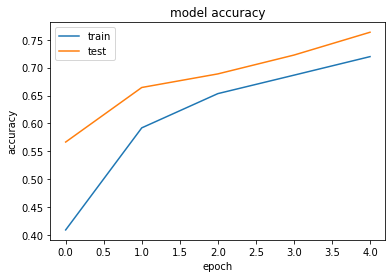

In [38]:
# visualization of model accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

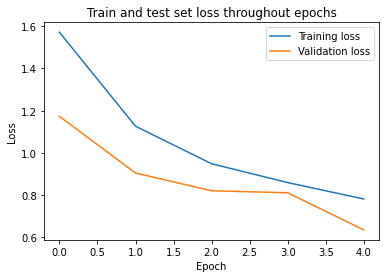

In [39]:
# visualization of model loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train and test set loss throughout epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training loss', 'Validation loss'], loc='upper right')
plt.show()

Looking at above visualizations, we can see that the accuracy is steadily rising for both the train and the test set, while the loss seems to fall for both sets over epochs. We can also observe the behaviour that the slope of the graph is steeper at first and the gets flatter with each epoch and that the accuracy as well as loss of test and train set are getting closer to each other.

Overall, we achieve a fairly good performance but in order to try and raise levels of accuracy (now above 75%), we will try and tune the model a bit further by implementing Tranfer Learning.

## Model tuning with Transfer Learning
Transfer learning is the idea of overcoming the isolated learning paradigm and utilizing knowledge acquired for one task to solve related ones. We teach a model to  do what human brains to on a daily:  what we acquire as knowledge while learning about one task, we utilize in the same way to solve related tasks.

To do so, we first import the _pre-made_ CNN VGG16, load it and freeze the first layers to save most of the information that is already embedded in our previous model.

In [40]:
#import VGG16 for transfer learning 
from keras.applications import VGG16

In [41]:
#load the model
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

#set image size
image_size = 64

In [42]:
#freeze all but last two layers
for layer in vgg_conv.layers[:-2]:
    layer.trainable = False

In [43]:
#check if successfull (if so, only last layers trainable - True)
for layer in vgg_conv.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fc4d779b4e0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fc4d7384438> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fc4d3223d68> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fc4d31b4128> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fc4d77c35c0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fc4d31df668> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fc4d31d9198> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fc4d31d9550> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fc4d31df2b0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fc4d317a080> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fc4d3180278> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 

We now add two more additional layers, a dense one and an output one, fixing the last one especially making sure its features match our classification problem (hence why 10 units and softmax activation for the multiclass classification).

In [44]:
#import our toolbox for it
from keras import models
from keras import layers
from keras import optimizers

In [45]:
#new model: classifier1
classifier1 = models.Sequential()

#add the vgg16 convolutional base model
classifier1.add(vgg_conv)
 
#new layers
classifier1.add(layers.Flatten())
classifier1.add(layers.Dense(1024, activation='relu'))
classifier1.add(layers.Dense(10, activation='softmax'))

In [46]:
#transfer learning
classifier1.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])
#adam vs rmsprop

In [47]:
#apply
history1 = classifier1.fit(training_set,
                         steps_per_epoch = 100, 
                         epochs = 4,
                         validation_data = test_set, validation_steps=100, batch_size=12)

Epoch 1/4
100/100 [==============================] - 277s 3s/step - loss: 1.8541 - accuracy: 0.4659 - val_loss: 1.0622 - val_accuracy: 0.5800
Epoch 2/4
100/100 [==============================] - 276s 3s/step - loss: 1.0464 - accuracy: 0.6267 - val_loss: 1.0250 - val_accuracy: 0.6091
Epoch 3/4
100/100 [==============================] - 276s 3s/step - loss: 0.9162 - accuracy: 0.6837 - val_loss: 0.6533 - val_accuracy: 0.7641
Epoch 4/4
100/100 [==============================] - 277s 3s/step - loss: 0.8253 - accuracy: 0.7113 - val_loss: 0.5639 - val_accuracy: 0.8150


In [48]:
#evaluate again
classifier1.evaluate(test_set, steps=125)

125/125 [==============================] - 169s 1s/step - loss: 0.5780 - accuracy: 0.8100


[0.5779709219932556, 0.8100000023841858]

At a first glance we can definitely see an improvement with the level of loss and accuracy of the model, going from loss of 0.64 to a loss of 0.57 and an accuracy score over 80% (previous one was 76%).

Let's have a further look at wha has actually happened as the model was being fitted and trained through loss and accuracy graphs.

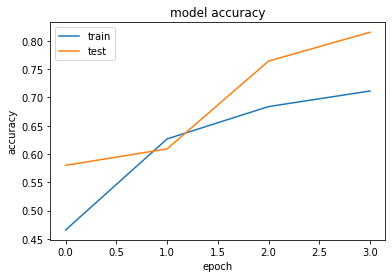

In [49]:
#visualization of model accuracy
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


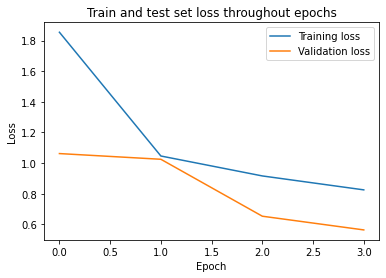

In [50]:
# visualization of model loss
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Train and test set loss throughout epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training loss', 'Validation loss'], loc='upper right')
plt.show()

The model did indeed perform well: accuracy is contanstly rising and loss is constantly falling throughout the epochs.

Transfer learning proved to be a successful tuning for the CNN model and we will now try and test it out with random pictures from the original dataset, to see if it can indeed predict the right class.

DISCLAIMER: be weary that when fitting the Transfer Learning model, sometimes it slows down and appears to be stuck after completing one epoch. This is an [issue](https://github.com/keras-team/keras/issues/8595) that many users have already pointed out.

##Predictions testing


First, we choose a random picture out of original 2750, we convert it into an array and get to _result_, which is the class prediction of the model we build.

In [52]:
#load test image and convert it into an array
test_image = image.load_img('/content/2750/Residential/Residential_1011.jpg', target_size = (64, 64))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)

#define result prediction
result = classifier1.predict(test_image)

In order to have the class prediction not as an array but as a label, we create a function that can print out said label.

In [53]:
#first, we have a look once again at the labels to write out the next function
print(training_set.class_indices)

{'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 'Pasture': 5, 'PermanentCrop': 6, 'Residential': 7, 'River': 8, 'SeaLake': 9}


In [55]:
#function to print out the label name
if result[0][0] == 1:
    prediction = 'AnnualCrop'
if result[0][1] == 1:
    prediction = 'Forest'
if result[0][2] == 1:
    prediction = 'HerbaceousVegetation'
if result[0][3] == 1:
    prediction = 'Highway'
if result[0][4] == 1:
    prediction = 'Industrial'
if result[0][5] == 1:
    prediction = 'Pasture'
if result[0][6] == 1:
    prediction = 'PermanentCrop'
if result[0][7] == 1:
    prediction = 'Residential'   
if result[0][8] == 1:
    prediction = 'River'
if result[0][9] == 1:
    prediction = 'SeaLake'
print('Image is:', prediction)

Image is: Industrial


The prediction is unfortunately wrong, but perhaps lets have a look on why that could be: could this image be really similar to an Industrial setting?

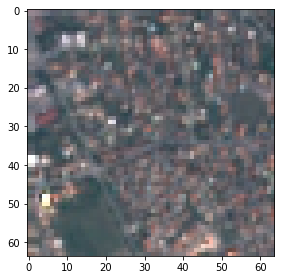

In [56]:
test_image_res = imread('/content/2750/Residential/Residential_1011.jpg')
imshow(test_image_res)

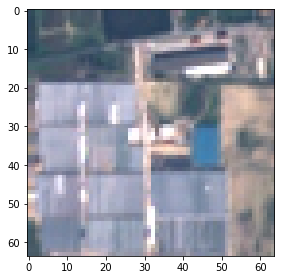

In [57]:
test_image_ind = imread('/content/2750/Industrial/Industrial_101.jpg')
imshow(test_image_ind);

Although the images are not exactly alike, there are some shapes and some colors that recurrent in both. The model after all didn't achieve very high levels of accuracy but the silver lining is that, between all the classes, it still predicted something somewhat similar to residential and not something completely random such as River or SeaLake.

Let's now test this Industry picture.

In [66]:
#2nd prediction test
test_image_i = image.load_img('/content/2750/Industrial/Industrial_101.jpg', target_size = (64, 64))
test_image_i = image.img_to_array(test_image_i)
test_image_i = np.expand_dims(test_image_i, axis = 0)

In [67]:
#results
result = classifier1.predict(test_image_i)

#function to print out the label name
if result[0][0] == 1:
    prediction = 'AnnualCrop'
if result[0][1] == 1:
    prediction = 'Forest'
if result[0][2] == 1:
    prediction = 'HerbaceousVegetation'
if result[0][3] == 1:
    prediction = 'Highway'
if result[0][4] == 1:
    prediction = 'Industrial'
if result[0][5] == 1:
    prediction = 'Pasture'
if result[0][6] == 1:
    prediction = 'PermanentCrop'
if result[0][7] == 1:
    prediction = 'Residential'   
if result[0][8] == 1:
    prediction = 'River'
if result[0][9] == 1:
    prediction = 'SeaLake'
print('Image is:', prediction)

Image is: Industrial


The prediction in this case is correct. We'll now also have a look at the original model now, before Transfer Learning was applied. We chose a Forest picture.

In [71]:
#3rd prediction test
test_image_f = image.load_img('/content/2750/Forest/Forest_1012.jpg', target_size = (64, 64))
test_image_f = image.img_to_array(test_image_f)
test_image_f = np.expand_dims(test_image_f, axis = 0)

In [73]:
#results
result = classifier.predict(test_image_f)

#function to print out the label name
if result[0][0] == 1:
    prediction = 'AnnualCrop'
if result[0][1] == 1:
    prediction = 'Forest'
if result[0][2] == 1:
    prediction = 'HerbaceousVegetation'
if result[0][3] == 1:
    prediction = 'Highway'
if result[0][4] == 1:
    prediction = 'Industrial'
if result[0][5] == 1:
    prediction = 'Pasture'
if result[0][6] == 1:
    prediction = 'PermanentCrop'
if result[0][7] == 1:
    prediction = 'Residential'   
if result[0][8] == 1:
    prediction = 'River'
if result[0][9] == 1:
    prediction = 'SeaLake'
print('Image is:', prediction)

Image is: Pasture


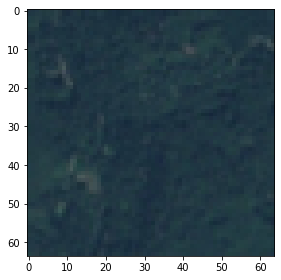

In [80]:
#show image
test_image_for = imread('/content/2750/Forest/Forest_1012.jpg')
imshow(test_image_for);

Once again, the prediction was not correct; however we can see how this could be easily mistaken for a pasture. The model is still "smart" enough to classify as something that could pass for a forest and not a River or an Industrial setting.

In [78]:
#4rd prediction test
test_image_h = image.load_img('/content/2750/Highway/Highway_1010.jpg', target_size = (64, 64))
test_image_h = image.img_to_array(test_image_h)
test_image_h = np.expand_dims(test_image_h, axis = 0)

In [79]:
#results
result = classifier.predict(test_image_h)

#function to print out the label name
if result[0][0] == 1:
    prediction = 'AnnualCrop'
if result[0][1] == 1:
    prediction = 'Forest'
if result[0][2] == 1:
    prediction = 'HerbaceousVegetation'
if result[0][3] == 1:
    prediction = 'Highway'
if result[0][4] == 1:
    prediction = 'Industrial'
if result[0][5] == 1:
    prediction = 'Pasture'
if result[0][6] == 1:
    prediction = 'PermanentCrop'
if result[0][7] == 1:
    prediction = 'Residential'   
if result[0][8] == 1:
    prediction = 'River'
if result[0][9] == 1:
    prediction = 'SeaLake'
print('Image is:', prediction)

Image is: Pasture


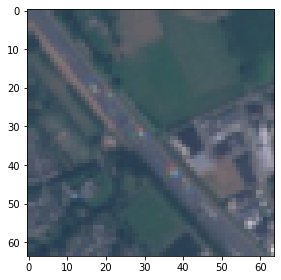

In [81]:
#show image
test_image_for = imread('/content/2750/Highway/Highway_1010.jpg')
imshow(test_image_for);

This seems to be a very odd results, however when looking at the picture below we can see how, with perhaps all that greenery surrounding the highway (which could indeed by farming land) could easily "trick" the model into believing it is a pasture land image.

# Conclusions
Finally, we can conclude that overall, our CNN deep learning model performed better than a standard non-neural baseline model (in this case, a RandomForestClassifier) in terms accuracy scores, especially after it was fine tuned through Transfer Learning.

As far as testing out the model, the predictions were not always correct: however, this could be easily linked to the quality of the data. It was perhaps the image low resolution as well as some shared similarities among these pictures and classes, that "tricked" the model predictions. 
As we have shown above, the model had in fact fairly good levels of accuracy and predictions errors could still be logically explained: perhaps obtaining satellite images of higher quality will be the final step to achieve the most accurate model for land use and land cover classification.